In [2]:
import torch
from d2l import torch as d2l
import numpy as np

In [3]:
x = torch.tensor([[1,2], [3,4]])
values, idxs = x.max(dim=0)

In [6]:
r1 = torch.arange(0,5)
r2 = torch.arange(0,10)

In [8]:
y, x = torch.meshgrid(r1, r2, indexing='ij')

In [10]:
y.reshape(-1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4])

In [4]:
x = torch.randn(1,3,5,4)

tuple(x.shape[-2:])

(5, 4)

In [367]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [13]:
# The first two sizes will represented 2(m-1) + 1 times. Other sizes will be represented once. Ratios will be represented n + 2 times.

def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + 2*num_ratios - 2)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]),
                  sizes[1] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
                   
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:]),
                   sizes[1] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

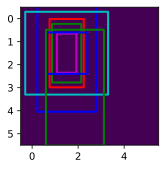

In [542]:
%matplotlib inline
torch.set_printoptions(2)

img = d2l.plt.imread('./datasets/32x32_img.jpg')

W, H = 6, 6
img = np.resize(img, (H, W))

X = torch.rand(1,3, H, W)
scales, ratios = [.6,.3,.35,.2], [0.5, 1]

num_anchors = len(scales) + 2 * len(ratios) -2

Y = multibox_prior(X, scales, ratios)
boxes = Y.reshape(H, W, num_anchors, 4)


labels = [f's={s}, r={ratios[0]}' for s in scales] + [f's={scales[0]},r={r}' for r in ratios[1:]]

d2l.set_figsize()
bbox_scale=torch.tensor((H, W, H, W))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, (torch.cat([boxes[1,1,:,:], torch.tensor([[0.1, 0.08, 0.52, 0.92]])], dim=0) * bbox_scale))

In [14]:
img = d2l.plt.imread('./datasets/32x32_img.jpg')

W, H = 6, 6
img = np.resize(img, (H, W))

X = torch.rand(1,3, H, W)
scales, ratios = [.6,.3,.35,.2], [0.5, 1]

num_anchors = len(scales) + 2 * len(ratios) -2

Y = multibox_prior(X, scales, ratios)
Y.shape

torch.Size([1, 216, 4])

In [527]:
x = torch.tensor([[1,2],[3,4]])
x.repeat(1,2)

tensor([[1, 2, 1, 2],
        [3, 4, 3, 4]])

In [528]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [488]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [489]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [543]:
labels = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92], [1, 0.55, 0.2, 0.9, 0.88], [2, 0.3, 0.2, 0.6, 0.5]]).unsqueeze(0)

anchors = boxes.reshape(-1, 4).unsqueeze(0)

In [544]:
batch_size, anchors = labels.shape[0], anchors.squeeze(0)

In [546]:
batch_offset, batch_mask, batch_class_labels = [], [], []
device, num_anchors = anchors.device, anchors.shape[0]

In [554]:
i = 0
label = labels[i, :, :]
label[:, 1:]
anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
indices_true = (anchors_bbox_map >= 0).nonzero() # get the idx of the anchor(s) which is assigned to the gt box 

In [548]:

class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)

In [549]:
bb_idx = anchors_bbox_map[indices_true]

In [550]:
class_labels[indices_true] = label[bb_idx, 0].long() + 1

In [ ]:
# (anchors_bbox_map == 2).nonzero()

In [551]:
# class_labels.view(H,W, num_anchors//(H*W))
assigned_bb[indices_true] = label[bb_idx, 1:]

In [561]:
offset = offset_boxes(anchors, assigned_bb) * bbox_mask

In [564]:
offset.reshape(-1).shape

torch.Size([864])

In [4]:
x = torch.tensor([0,1,2,3])
y = torch.tensor([0,1,2])

x1, y1 = torch.meshgrid([x,y], indexing='ij')

def make_tuple(x,y):
    return tuple([x, y])

F = np.vectorize(make_tuple)

F(x1,y1)

(array([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]], dtype=int64),
 array([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]], dtype=int64))

In [1]:
t = (1,2)
(0,*t)

(0, 1, 2)